# Tool Performance Comparison on IMG/VR4 Real Data

This notebook analyzes tool performance on real CRISPR spacer data from IMG/VR4 across multiple dataset fractions.

## Analysis Strategy

We use multi-metric validation (from `distance_metric_analysis.ipynb`) to:
- Validate all unique alignments using parasail (hamming, edit, and gap-affine distances)
- Focus on **Hamming distance ≤ 3** for the main analysis
- Use `region_idx` to properly group alignments within coordinate tolerance (avoids double-counting)
- Compare tool performance across dataset sizes
- Track which tools completed successfully and which timed out

**Key Difference from Simulated Analysis**: No ground truth means we can't calculate recall/precision directly. Instead, we focus on:
- Tool agreement (upset plots, comparison matrices)
- Performance consistency across dataset fractions (enables extrapolation)
- Validated alignment counts per tool
- Unique detections and overlaps

**Dataset Fractions**: Automatically discovers and analyzes all available fractions, tracking:
- Dataset size (bp, number of contigs, file size)
- Which tools completed successfully
- Which tools timed out or weren't run
- Total unique alignment regions (using coordinate tolerance)

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

os.chdir('/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/')

import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import json
from pathlib import Path
import pyfastx as pfx

from bench.utils.functions import *
from bench.commands.compare_results import analyze_simulation_multi_metric
from lets_plot import *
import altair as alt
import upsetplot as up

pl.Config.set_tbl_rows(50)
pl.Config.set_tbl_cols(-1)
LetsPlot.setup_html()

# Load tool styles for consistent colors and markers
with open('notebooks/tool_styles.json', 'r') as f:
    TOOL_STYLES = json.load(f)

tool_colors = {tool: styles['color'] for tool, styles in TOOL_STYLES.items()}
tool_shapes = {tool: styles['letsplot_shape_num'] for tool, styles in TOOL_STYLES.items()}

# Analysis configuration
MAX_HAMMING_DISTANCE = 3
COORDINATE_TOLERANCE = 5
GAP_OPEN_PENALTY = 5
GAP_EXTEND_PENALTY = 5

# Dataset paths
BASE_DIR = Path('/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench')
SPACERS_FILE = str(BASE_DIR / 'imgvr4_data/spacers/iphop_filtered_spacers.fna')
RESULTS_BASE_DIR = Path('results/real_data/subsamples')
OUTPUT_DIR = Path('results/real_data/subsamples_analysis')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Configuration: Hamming ≤ {MAX_HAMMING_DISTANCE}, Coordinate tolerance: {COORDINATE_TOLERANCE} bp")
print(f"Loaded tool styles for {len(TOOL_STYLES)} tools")

Configuration: Hamming ≤ 3, Coordinate tolerance: 5 bp
Loaded tool styles for 11 tools


## Step 1: Auto-Discover Fractions and Gather Metadata

Automatically discover all available dataset fractions and collect metadata including:
- Dataset characteristics (size, number of contigs)
- Tool completion status
- Timeout information from slurm logs

In [2]:
def get_fraction_metadata(fraction_dir):
    """
    Get metadata for a fraction including dataset size, number of contigs,
    which tools completed, and which timed out.
    
    Returns dict with keys: fraction_name, n_contigs, total_bp, size_mb, 
                           completed_tools, timed_out_tools, n_tools_completed
    """
    fraction_name = fraction_dir.name
    metadata = {
        'fraction': fraction_name,
        'fraction_value': float(fraction_name.replace('fraction_', '')),
    }
    
    # Get contig file stats
    contig_file = fraction_dir / 'subsampled_data' / 'subsampled_contigs.fa'
    if contig_file.exists():
        fa = pfx.Fasta(str(contig_file))
        metadata['n_contigs'] = len(fa)
        metadata['total_bp'] = sum(len(seq) for seq in fa)
        metadata['size_mb'] = contig_file.stat().st_size / 1e6
    else:
        metadata['n_contigs'] = 0
        metadata['total_bp'] = 0
        metadata['size_mb'] = 0

    # Check which tools completed by looking for output files
    raw_outputs_dir = fraction_dir / 'raw_outputs'
    expected_outputs = {
        'blastn': 'blastn_output.tsv',
        'bowtie1': 'bowtie1_output.sam',
        'bowtie2': 'bowtie2_output.sam',
        'indelfree_bruteforce': 'indelfree_bruteforce_output.sam',
        'indelfree_indexed': 'indelfree_indexed_output.sam',
        'minimap2': 'minimap2_output.sam',
        'mmseqs2': 'mmseqs_output.tsv',
        'mummer4': 'mummer4_output.sam',
        'sassy': 'sassy.tsv',
        'strobealign': 'strobealign_output.sam',
        'x_mapper': 'x_mapper_output.sam',
    }
    
    completed_tools = []
    missing_tools = []
    
    for tool, output_file in expected_outputs.items():
        output_path = raw_outputs_dir / output_file
        if output_path.exists() and output_path.stat().st_size > 0:
            completed_tools.append(tool)
        else:
            missing_tools.append(tool)
    
    # Check slurm logs for timeouts
    timed_out_tools = []
    slurm_logs_dir = fraction_dir / 'slurm_logs'
    if slurm_logs_dir.exists():
        for tool in expected_outputs.keys():
            for log_file in slurm_logs_dir.glob(f'{tool}*.err'):
                try:
                    with open(log_file, 'r') as f:
                        content = f.read()
                        if 'TIMEOUT' in content or 'CANCELLED' in content or 'DUE TO TIME LIMIT' in content:
                            timed_out_tools.append(tool)
                            if tool in completed_tools:
                                completed_tools.remove(tool)
                            break
                except:
                    pass
    
    metadata['completed_tools'] = sorted(completed_tools)
    metadata['timed_out_tools'] = sorted(set(timed_out_tools))
    metadata['missing_tools'] = sorted(set(missing_tools) - set(timed_out_tools))
    metadata['n_tools_completed'] = len(completed_tools)
    
    return metadata

# Discover all fractions
all_fractions = sorted([d for d in RESULTS_BASE_DIR.iterdir() if d.is_dir() and d.name.startswith('fraction_')],
                       key=lambda x: float(x.name.replace('fraction_', '')))

fractions_metadata = [get_fraction_metadata(fraction_dir) for fraction_dir in all_fractions]
fractions_df = pl.DataFrame(fractions_metadata)

print(f"Discovered {len(all_fractions)} fractions")
print("\nFraction Overview:")
print(fractions_df.select(['fraction', 'n_contigs', 'total_bp', 'size_mb', 'n_tools_completed']))

# Detailed tool completion status
print("\nTool Completion Status by Fraction:")
for row in fractions_df.iter_rows(named=True):
    print(f"\n{row['fraction']} ({row['n_tools_completed']} tools completed):")
    if row['completed_tools']:
        print(f"  Completed: {', '.join(row['completed_tools'])}")
    if row['timed_out_tools']:
        print(f"  Timed out: {', '.join(row['timed_out_tools'])}")
    if row['missing_tools']:
        print(f"  Missing/Not run: {', '.join(row['missing_tools'])}")

Discovered 7 fractions

Fraction Overview:
shape: (7, 5)
┌─────────────────┬───────────┬─────────────┬──────────────┬───────────────────┐
│ fraction        ┆ n_contigs ┆ total_bp    ┆ size_mb      ┆ n_tools_completed │
│ ---             ┆ ---       ┆ ---         ┆ ---          ┆ ---               │
│ str             ┆ i64       ┆ i64         ┆ f64          ┆ i64               │
╞═════════════════╪═══════════╪═════════════╪══════════════╪═══════════════════╡
│ fraction_0.0005 ┆ 279       ┆ 7036591     ┆ 7.053331     ┆ 11                │
│ fraction_0.001  ┆ 421       ┆ 9745671     ┆ 9.770854     ┆ 11                │
│ fraction_0.005  ┆ 2107      ┆ 57059412    ┆ 57.186897    ┆ 10                │
│ fraction_0.01   ┆ 4214      ┆ 123668270   ┆ 123.924622   ┆ 10                │
│ fraction_0.05   ┆ 21071     ┆ 715073062   ┆ 716.359075   ┆ 9                 │
│ fraction_0.1    ┆ 42143     ┆ 1504536616  ┆ 1507.113929  ┆ 9                 │
│ fraction_1      ┆ 421431    ┆ 18870643188 ┆ 18896.

## Step 2: Generate Multi-Metric Validation for All Fractions

Use `analyze_simulation_multi_metric` to validate all unique alignments across all fractions. This validates each alignment using parasail with three distance metrics (Hamming, Edit, and Gap-affine distances).

**Key points:**
- Processes all discovered fractions automatically
- Uses `region_idx` to group alignments within coordinate tolerance
- Saves results to parquet for efficient querying

In [3]:
for fraction_row in fractions_df.iter_rows(named=True):
    fraction_name = fraction_row['fraction']
    fraction_dir = RESULTS_BASE_DIR / fraction_name
    output_parquet = OUTPUT_DIR / f"multi_metric_{fraction_name}.parquet"
    
    if output_parquet.exists():
        print(f"✓ {fraction_name}: Multi-metric validation exists ({output_parquet.stat().st_size / 1e9:.2f} GB)")
        continue
    
    print(f"\nProcessing {fraction_name}...")
    print(f"  Contigs: {fraction_row['n_contigs']:,} ({fraction_row['total_bp']:,} bp)")
    print(f"  Tools completed: {fraction_row['n_tools_completed']}")
    
    # Run multi-metric validation
    multi_metric_results = analyze_simulation_multi_metric(
        sim_dir=str(fraction_dir),
        max_distance_threshold=MAX_HAMMING_DISTANCE,
        coordinate_tolerance=COORDINATE_TOLERANCE,
        gap_open=GAP_OPEN_PENALTY,
        gap_extend=GAP_EXTEND_PENALTY,
        spacer_file=SPACERS_FILE,
        contig_file=str(fraction_dir / 'subsampled_data' / 'subsampled_contigs.fa'),
        ground_truth_file=None,
    )
    
    multi_metric_results.write_parquet(str(output_parquet))
    print(f"  Saved {multi_metric_results.height:,} unique alignments ({output_parquet.stat().st_size / 1e9:.2f} GB)")

print("\nMulti-metric validation complete for all fractions")

✓ fraction_0.0005: Multi-metric validation exists (0.00 GB)
✓ fraction_0.001: Multi-metric validation exists (0.00 GB)
✓ fraction_0.005: Multi-metric validation exists (0.01 GB)
✓ fraction_0.01: Multi-metric validation exists (0.02 GB)
✓ fraction_0.05: Multi-metric validation exists (0.07 GB)
✓ fraction_0.1: Multi-metric validation exists (0.14 GB)
✓ fraction_1: Multi-metric validation exists (1.74 GB)

Multi-metric validation complete for all fractions


## Step 3: Multi-Fraction Tool Recall Analysis

Compare tool performance across all dataset fractions to understand how recall scales with dataset size. This analysis shows:

- **Mean recall ± standard deviation** across all fractions for each tool
- **Performance consistency** - tools with low std are reliable across dataset sizes
- **Scaling behavior** - how tools perform as dataset size changes

This analysis justifies extrapolating results from completed tools to estimate performance of tools that timed out on larger fractions.

### Load Recall Data from All Fractions

In [4]:
all_fractions_data = []

for fraction_row in fractions_df.iter_rows(named=True):
    fraction_name = fraction_row['fraction']
    parquet_file = OUTPUT_DIR / f'multi_metric_{fraction_name}.parquet'
    
    if not parquet_file.exists():
        print(f"⚠ Skipping {fraction_name}: multi-metric file not found")
        continue
    
    print(f"Loading {fraction_name}...")
    fraction_df = pl.read_parquet(parquet_file)
    fraction_results = fraction_df.filter(
        pl.col('distance_hamming') <= MAX_HAMMING_DISTANCE
    ).explode('tools').rename({'tools': 'tool'})
    
    tools_in_fraction = fraction_results.select('tool').unique()['tool'].to_list()
    
    # Calculate cumulative recall at hamming ≤ 3 using region_idx
    total_regions = fraction_results.select(['spacer_id', 'contig_id', 'region_idx']).unique().height
    
    for tool in tools_in_fraction:
        tool_regions = fraction_results.filter(
            pl.col('tool') == tool
        ).select(['spacer_id', 'contig_id', 'region_idx']).unique().height
        
        recall = tool_regions / total_regions if total_regions > 0 else 0
        
        all_fractions_data.append({
            'fraction': fraction_name,
            'fraction_value': fraction_row['fraction_value'],
            'tool': tool,
            'recall': recall,
            'n_regions': tool_regions,
            'total_possible': total_regions,
            'n_contigs': fraction_row['n_contigs'],
            'total_bp': fraction_row['total_bp'],
        })

all_fractions_df = pl.DataFrame(all_fractions_data)

print(f"\nLoaded {all_fractions_df['fraction'].n_unique()} fractions")
print(f"Total rows: {all_fractions_df.height:,}")
print(f"Tools found: {sorted(all_fractions_df['tool'].unique().to_list())}")

all_fractions_df.head(20)

Loading fraction_0.0005...
Loading fraction_0.001...
Loading fraction_0.005...
Loading fraction_0.01...
Loading fraction_0.05...
Loading fraction_0.1...
Loading fraction_1...

Loaded 7 fractions
Total rows: 71
Tools found: ['blastn', 'bowtie1', 'bowtie2', 'indelfree_bruteforce', 'indelfree_indexed', 'minimap2', 'mmseqs2', 'mummer4', 'sassy', 'strobealign', 'x_mapper']


fraction,fraction_value,tool,recall,n_regions,total_possible,n_contigs,total_bp
str,f64,str,f64,i64,i64,i64,i64
"""fraction_0.0005""",0.0005,"""indelfree_indexed""",1.0,13988,13988,279,7036591
"""fraction_0.0005""",0.0005,"""strobealign""",0.692808,9691,13988,279,7036591
"""fraction_0.0005""",0.0005,"""mummer4""",0.559551,7827,13988,279,7036591
"""fraction_0.0005""",0.0005,"""sassy""",0.978124,13682,13988,279,7036591
"""fraction_0.0005""",0.0005,"""x_mapper""",0.827781,11579,13988,279,7036591
"""fraction_0.0005""",0.0005,"""indelfree_bruteforce""",1.0,13988,13988,279,7036591
"""fraction_0.0005""",0.0005,"""bowtie1""",1.0,13988,13988,279,7036591
"""fraction_0.0005""",0.0005,"""blastn""",0.79032,11055,13988,279,7036591
"""fraction_0.0005""",0.0005,"""mmseqs2""",0.757006,10589,13988,279,7036591


### Error Bar Plot: Performance Consistency Analysis

This plot shows mean recall ± standard deviation across all fractions, revealing which tools are most reliable across different dataset sizes. Low error bars indicate consistent performance regardless of dataset size.

In [5]:
# Calculate summary statistics for each tool
all_tools = sorted(set(tool_colors.keys()) | set(all_fractions_df['tool'].unique().to_list()))

tool_stats = []
for tool in all_tools:
    tool_data = all_fractions_df.filter(pl.col('tool') == tool)
    
    if tool_data.height > 0:
        mean_recall = tool_data['recall'].mean()
        std_recall = tool_data['recall'].std()
        min_recall = tool_data['recall'].min()
        max_recall = tool_data['recall'].max()
        n_fractions = tool_data.height
    else:
        mean_recall = 0.0
        std_recall = 0.0
        min_recall = 0.0
        max_recall = 0.0
        n_fractions = 0
    
    tool_stats.append({
        'tool': tool,
        'mean_recall': mean_recall,
        'std_recall': std_recall if std_recall is not None else 0.0,
        'min_recall': min_recall,
        'max_recall': max_recall,
        'lower_error': mean_recall - (std_recall if std_recall is not None else 0.0),
        'upper_error': mean_recall + (std_recall if std_recall is not None else 0.0),
        'n_fractions': n_fractions
    })

tool_stats_df = pl.DataFrame(tool_stats)
error_bar_data = tool_stats_df.to_dict(as_series=False)

# Create error bar plot
error_bar_chart = (
    ggplot(error_bar_data, aes(x='tool', y='mean_recall')) +
    geom_errorbar(aes(ymin='lower_error', ymax='upper_error'), width=0.3, size=1) +
    geom_point(aes(color='tool'), size=4, shape=19) +
    scale_color_manual(values=tool_colors, name='Tool') +
    scale_y_continuous(limits=[0, 1.05]) +
    labs(
        x='Tool',
        y='Mean Recall ± Std (across all fractions)',
        title='Tool Performance Consistency Across Dataset Sizes (Hamming ≤ 3)'
    ) +
    ggsize(800, 500) +
    theme_minimal() +
    theme(
        plot_title=element_text(size=14, face='bold'),
        axis_text_x=element_text(angle=45, hjust=1),
        legend_position='none'
    )
)

ggsave(error_bar_chart, str(OUTPUT_DIR / 'recall_error_bars_by_tool.html'))
ggsave(error_bar_chart, str(OUTPUT_DIR / 'recall_error_bars_by_tool.svg'))

tool_stats_df.write_csv(str(OUTPUT_DIR / 'tool_recall_stats_across_fractions.tsv'), separator='\t')

print(f"Tool Statistics (n={len(all_tools)} tools):")
print(tool_stats_df.sort('mean_recall', descending=True))

error_bar_chart

Tool Statistics (n=11 tools):
shape: (11, 8)
┌──────────────────────┬─────────────┬────────────┬────────────┬────────────┬─────────────┬─────────────┬─────────────┐
│ tool                 ┆ mean_recall ┆ std_recall ┆ min_recall ┆ max_recall ┆ lower_error ┆ upper_error ┆ n_fractions │
│ ---                  ┆ ---         ┆ ---        ┆ ---        ┆ ---        ┆ ---         ┆ ---         ┆ ---         │
│ str                  ┆ f64         ┆ f64        ┆ f64        ┆ f64        ┆ f64         ┆ f64         ┆ i64         │
╞══════════════════════╪═════════════╪════════════╪════════════╪════════════╪═════════════╪═════════════╪═════════════╡
│ bowtie1              ┆ 0.999929    ┆ 0.000033   ┆ 0.999904   ┆ 1.0        ┆ 0.999896    ┆ 0.999962    ┆ 7           │
│ sassy                ┆ 0.976917    ┆ 0.002586   ┆ 0.973955   ┆ 0.97983    ┆ 0.974331    ┆ 0.979502    ┆ 4           │
│ bowtie2              ┆ 0.97086     ┆ 0.003613   ┆ 0.965613   ┆ 0.977058   ┆ 0.967247    ┆ 0.974473    ┆ 7        

### Summary Table for Paper

Comprehensive table showing dataset characteristics, analysis results, and tool completion status for each fraction.

In [6]:
# Create comprehensive summary table combining metadata and analysis results
summary_table_data = []

for fraction_row in fractions_df.iter_rows(named=True):
    fraction_name = fraction_row['fraction']
    parquet_file = OUTPUT_DIR / f'multi_metric_{fraction_name}.parquet'
    
    if parquet_file.exists():
        # Load to get alignment counts
        fraction_df = pl.read_parquet(parquet_file)
        fraction_results = fraction_df.filter(pl.col('distance_hamming') <= MAX_HAMMING_DISTANCE)
        
        # Count using region_idx to avoid double-counting alignments with slight boundary shifts
        total_unique_regions = fraction_results.select(['spacer_id', 'contig_id', 'region_idx']).unique().height
        total_alignments_raw = fraction_results.height
    else:
        total_unique_regions = 0
        total_alignments_raw = 0
    
    summary_table_data.append({
        'fraction': fraction_name,
        'fraction_value': fraction_row['fraction_value'],
        'n_contigs': fraction_row['n_contigs'],
        'total_bp': fraction_row['total_bp'],
        'size_mb': fraction_row['size_mb'],
        'n_tools_completed': fraction_row['n_tools_completed'],
        'total_unique_regions': total_unique_regions,
        'total_alignments_raw': total_alignments_raw,
        'completed_tools': ', '.join(fraction_row['completed_tools']),
        'timed_out_tools': ', '.join(fraction_row['timed_out_tools']) if fraction_row['timed_out_tools'] else 'None',
        'missing_tools': ', '.join(fraction_row['missing_tools']) if fraction_row['missing_tools'] else 'None',
    })

summary_table_df = pl.DataFrame(summary_table_data)

# Save for paper
summary_table_df.write_csv(str(OUTPUT_DIR / 'summary_table_for_paper.tsv'), separator='\t')
summary_table_df.write_csv(str(OUTPUT_DIR / 'summary_table_for_paper.csv'))

print("Summary Table (for paper):")
print(summary_table_df.select([
    'fraction', 'n_contigs', 'total_bp', 'size_mb', 
    'n_tools_completed', 'total_unique_regions'
]))

print("\nFull table saved to:")
print(f"  {OUTPUT_DIR / 'summary_table_for_paper.tsv'}")
print(f"  {OUTPUT_DIR / 'summary_table_for_paper.csv'}")

summary_table_df

Summary Table (for paper):
shape: (7, 6)
┌─────────────────┬───────────┬─────────────┬──────────────┬───────────────────┬──────────────────────┐
│ fraction        ┆ n_contigs ┆ total_bp    ┆ size_mb      ┆ n_tools_completed ┆ total_unique_regions │
│ ---             ┆ ---       ┆ ---         ┆ ---          ┆ ---               ┆ ---                  │
│ str             ┆ i64       ┆ i64         ┆ f64          ┆ i64               ┆ i64                  │
╞═════════════════╪═══════════╪═════════════╪══════════════╪═══════════════════╪══════════════════════╡
│ fraction_0.0005 ┆ 279       ┆ 7036591     ┆ 7.053331     ┆ 11                ┆ 13988                │
│ fraction_0.001  ┆ 421       ┆ 9745671     ┆ 9.770854     ┆ 11                ┆ 20922                │
│ fraction_0.005  ┆ 2107      ┆ 57059412    ┆ 57.186897    ┆ 10                ┆ 74027                │
│ fraction_0.01   ┆ 4214      ┆ 123668270   ┆ 123.924622   ┆ 10                ┆ 172099               │
│ fraction_0.05   ┆ 210

fraction,fraction_value,n_contigs,total_bp,size_mb,n_tools_completed,total_unique_regions,total_alignments_raw,completed_tools,timed_out_tools,missing_tools
str,f64,i64,i64,f64,i64,i64,i64,str,str,str
"""fraction_0.0005""",0.0005,279,7036591,7.053331,11,13988,24872,"""blastn, bowtie1, bowtie2, indelfree_bruteforce, indelfree_indexed, minimap2, mmseqs2, mummer4, sassy, strobealign, x_mapper""","""None""","""None"""
"""fraction_0.001""",0.001,421,9745671,9.770854,11,20922,37038,"""blastn, bowtie1, bowtie2, indelfree_bruteforce, indelfree_indexed, minimap2, mmseqs2, mummer4, sassy, strobealign, x_mapper""","""None""","""None"""
"""fraction_0.005""",0.005,2107,57059412,57.186897,10,74027,124726,"""blastn, bowtie1, bowtie2, indelfree_indexed, minimap2, mmseqs2, mummer4, sassy, strobealign, x_mapper""","""indelfree_bruteforce""","""None"""
"""fraction_0.01""",0.01,4214,123668270,123.924622,10,172099,281364,"""blastn, bowtie1, bowtie2, indelfree_indexed, minimap2, mmseqs2, mummer4, sassy, strobealign, x_mapper""","""indelfree_bruteforce""","""None"""
"""fraction_0.05""",0.05,21071,715073062,716.359075,9,864911,1298329,"""blastn, bowtie1, bowtie2, indelfree_indexed, minimap2, mmseqs2, mummer4, strobealign, x_mapper""","""None""","""indelfree_bruteforce, sassy"""
"""fraction_0.1""",0.1,42143,1504536616,1507.113929,9,1852959,2711599,"""blastn, bowtie1, bowtie2, indelfree_indexed, minimap2, mmseqs2, mummer4, strobealign, x_mapper""","""None""","""indelfree_bruteforce, sassy"""
"""fraction_1""",1.0,421431,18870643188,18896.546044,8,23288071,30916244,"""blastn, bowtie1, bowtie2, minimap2, mmseqs2, mummer4, strobealign, x_mapper""","""indelfree_indexed""","""indelfree_bruteforce, sassy"""


### Recall Pivot Table

Tool recall by fraction showing which tools ran on which datasets.

In [7]:
# Create pivot table showing recall by tool and fraction
recall_pivot = all_fractions_df.select(['tool', 'fraction', 'recall']).pivot(
    index='tool',
    on='fraction',
    values='recall'
).sort('tool')

recall_pivot.write_csv(str(OUTPUT_DIR / 'recall_by_fraction_pivot.tsv'), separator='\t')

print("Tool Recall by Dataset Fraction (Hamming ≤ 3):")
print(f"{recall_pivot.height} tools across {len(all_fractions_df['fraction'].unique())} fractions")
print("Note: null values indicate the tool didn't run on that fraction\n")
recall_pivot

Tool Recall by Dataset Fraction (Hamming ≤ 3):
11 tools across 7 fractions
Note: null values indicate the tool didn't run on that fraction



tool,fraction_0.0005,fraction_0.001,fraction_0.005,fraction_0.01,fraction_0.05,fraction_0.1,fraction_1
str,f64,f64,f64,f64,f64,f64,f64
"""blastn""",0.79032,0.793136,0.777406,0.783241,0.780848,0.778357,0.786636
"""bowtie1""",1.0,0.999904,0.999905,0.99993,0.999927,0.99991,0.999928
"""bowtie2""",0.965613,0.977058,0.967944,0.972586,0.970443,0.970686,0.97169
"""indelfree_bruteforce""",1.0,0.999952,0.964486,0.304214,null,null,null
"""indelfree_indexed""",1.0,0.999952,0.999946,0.999936,0.999919,0.999913,0.138362
"""minimap2""",0.0005,0.000621,0.000702,0.000424,0.000288,0.000323,0.000322
"""mmseqs2""",0.757006,0.776503,0.743985,0.753351,0.747362,0.744446,0.734705
"""mummer4""",0.559551,0.563952,0.528307,0.536738,0.533549,0.528046,0.545104
"""sassy""",0.978124,0.97983,0.973955,0.975758,null,null,null


## Step 4: Detailed Analysis for Fraction_1

Load the full dataset (fraction_1) for detailed tool comparison including upset plots, comparison matrices, and performance by hamming distance.

In [32]:
# Load fraction_1 results for detailed analysis
multi_metric_file = OUTPUT_DIR / 'multi_metric_fraction_1.parquet'

print("Loading fraction_1 results...")
results_df = pl.read_parquet(multi_metric_file)

# Get fraction_1 metadata to identify timed-out tools
fraction_1_metadata = fractions_df.filter(pl.col('fraction') == 'fraction_1').to_dicts()[0]
timed_out_tools_fraction_1 = fraction_1_metadata['timed_out_tools']

print(f"Excluding timed-out tools from fraction_1 analysis: {timed_out_tools_fraction_1}")

# Filter for Hamming ≤ 3 and explode tools column
results_hamming3 = results_df.filter(
    pl.col('distance_hamming') <= MAX_HAMMING_DISTANCE
).explode('tools').rename({'tools': 'tool'})

# Exclude timed-out tools (partial results)
if timed_out_tools_fraction_1:
    results_hamming3 = results_hamming3.filter(~pl.col('tool').is_in(timed_out_tools_fraction_1))

print(f"Total unique alignments: {results_df.height:,}")
print(f"Filtered to Hamming ≤ {MAX_HAMMING_DISTANCE}: {results_hamming3.height:,} alignments (long format)")
print(f"Unique alignment regions (using region_idx): {results_hamming3.select('region_idx').n_unique():,}")

tools_in_results = results_hamming3.select('tool').unique().sort('tool')['tool'].to_list()
print(f"Tools (excluding timed-out): {tools_in_results}")

# Create plot directory
plot_dir = OUTPUT_DIR / 'plots_fraction_1'
plot_dir.mkdir(parents=True, exist_ok=True)

Loading fraction_1 results...
Excluding timed-out tools from fraction_1 analysis: ['indelfree_indexed']
Total unique alignments: 31,505,525
Filtered to Hamming ≤ 3: 121,088,278 alignments (long format)
Unique alignment regions (using region_idx): 23,288,071
Tools (excluding timed-out): ['blastn', 'bowtie1', 'bowtie2', 'minimap2', 'mmseqs2', 'mummer4', 'strobealign', 'x_mapper']


### Tool Performance Summary

In [33]:
# Generate per-tool summary statistics
summary_stats = results_hamming3.group_by('tool').agg([
    pl.len().alias('n_alignments'),
    pl.col('spacer_id').n_unique().alias('n_spacers'),
    pl.col('contig_id').n_unique().alias('n_contigs'),
    pl.col('distance_hamming').mean().alias('mean_hamming'),
    pl.col('distance_hamming').median().alias('median_hamming'),
    pl.col('distance_hamming').min().alias('min_hamming'),
    pl.col('distance_hamming').max().alias('max_hamming'),
]).sort('n_alignments', descending=True)

summary_stats.write_csv(str(OUTPUT_DIR / 'tool_summary_fraction_1.tsv'), separator='\t')

print("Tool Performance Summary (Hamming ≤ 3):")
summary_stats

Tool Performance Summary (Hamming ≤ 3):


tool,n_alignments,n_spacers,n_contigs,mean_hamming,median_hamming,min_hamming,max_hamming
str,u64,u64,u64,f64,f64,i64,i64
"""bowtie1""",25463659,750231,323178,1.377189,1.0,0,3
"""bowtie2""",24768842,730262,284320,1.332368,1.0,0,3
"""blastn""",20142598,649595,273656,1.144347,1.0,0,3
"""mmseqs2""",18797418,633225,222783,1.023763,1.0,0,3
"""mummer4""",14383138,505144,190848,0.646097,0.0,0,3
"""strobealign""",9396840,511202,173472,0.474642,0.0,0,3
"""x_mapper""",8128274,425192,157138,0.68666,0.0,0,3
"""minimap2""",7509,816,5300,0.0,0.0,0,0


### Matched Contigs Analysis

In [34]:
# Identify contigs matched by spacers using region_idx for proper grouping
unique_regions = results_hamming3.select([
    'spacer_id', 'contig_id', 'region_idx', 'strand', 'tool'
]).unique()

matched_contigs = unique_regions.group_by('contig_id').agg([
    pl.col('spacer_id').n_unique().alias('n_spacers'),
    pl.col('region_idx').n_unique().alias('n_regions'),
    pl.col('tool').unique().alias('tools'),
    pl.col('tool').n_unique().alias('n_tools'),
]).sort('n_spacers', descending=True)

print("Top 10 contigs by spacer matches:")
print(matched_contigs.head(10))

print(f"\nTotal contigs matched: {matched_contigs.height:,}")
print(f"Contigs matched by all tools: {matched_contigs.filter(pl.col('n_tools') == len(tools_in_results)).height:,}")

Top 10 contigs by spacer matches:
shape: (10, 5)
┌───────────────────────────────────────────────────────────┬───────────┬───────────┬──────────────────────────────────────────┬─────────┐
│ contig_id                                                 ┆ n_spacers ┆ n_regions ┆ tools                                    ┆ n_tools │
│ ---                                                       ┆ ---       ┆ ---       ┆ ---                                      ┆ ---     │
│ str                                                       ┆ u64       ┆ u64       ┆ list[str]                                ┆ u64     │
╞═══════════════════════════════════════════════════════════╪═══════════╪═══════════╪══════════════════════════════════════════╪═════════╡
│ IMGVR_UViG_3300045988_102190|3300045988|Ga0495776_114311  ┆ 4188      ┆ 4253      ┆ ["mmseqs2", "blastn", … "minimap2"]      ┆ 8       │
│ IMGVR_UViG_3300045988_086093|3300045988|Ga0495776_169011  ┆ 4120      ┆ 4146      ┆ ["blastn", "strobealign", … "mi

### Tool Overlap Analysis - Upset Plots

Visualize set intersections showing which unique alignments are detected by which tool combinations, stratified by exact Hamming distance.

Generating upset plot for Hamming distance = 0
  Unique regions: 7,486,844, Tool combinations: 7,486,844


/tmp/ipykernel_1932608/3512946823.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

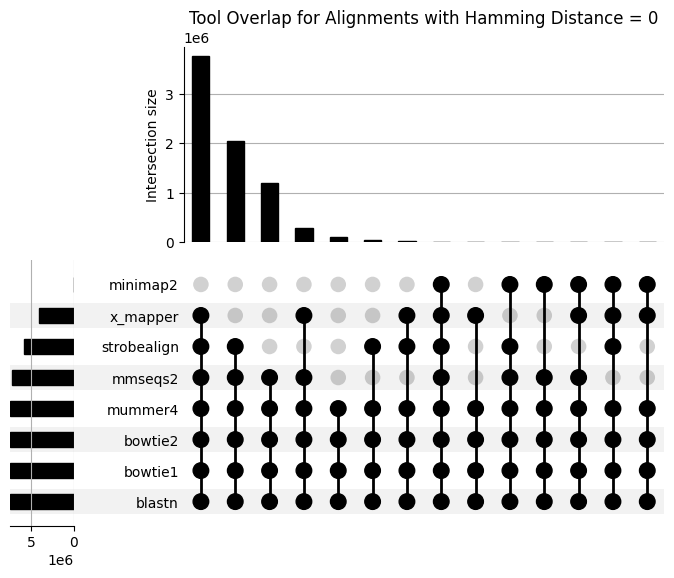

Generating upset plot for Hamming distance = 1
  Unique regions: 5,350,310, Tool combinations: 5,350,310


/tmp/ipykernel_1932608/3512946823.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

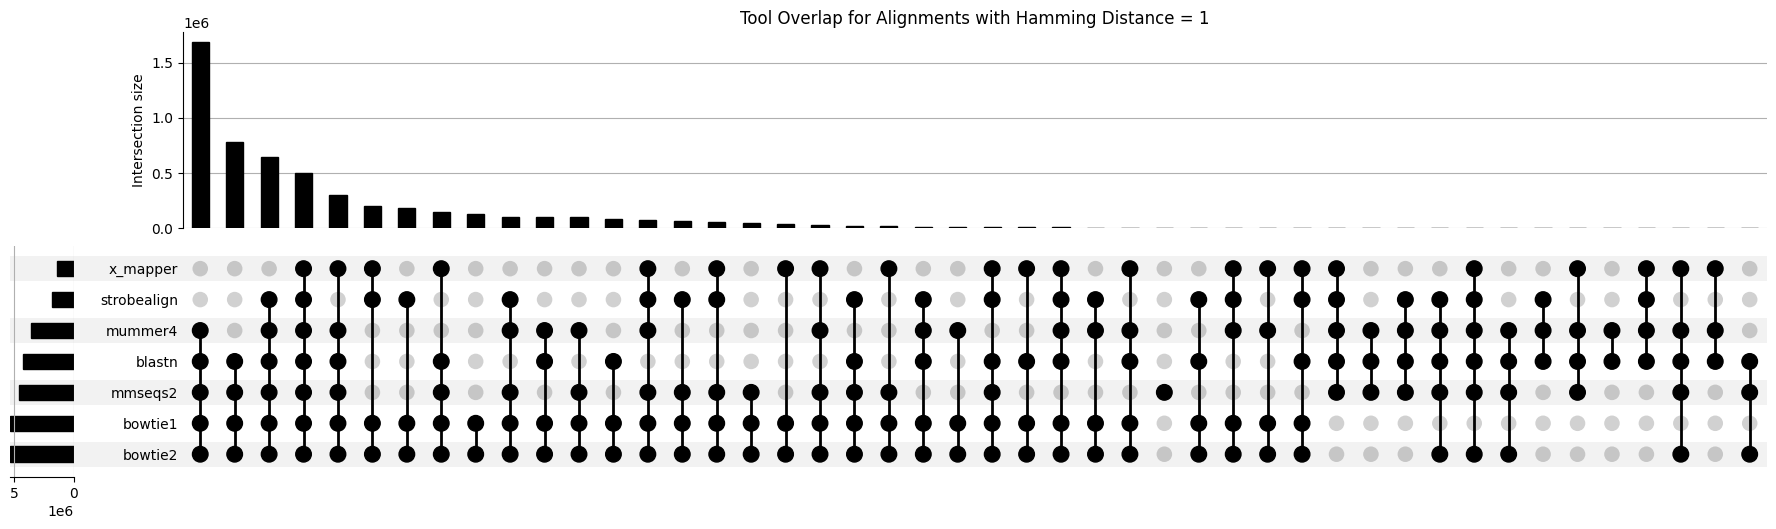

Generating upset plot for Hamming distance = 2
  Unique regions: 5,194,444, Tool combinations: 5,194,444


/tmp/ipykernel_1932608/3512946823.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

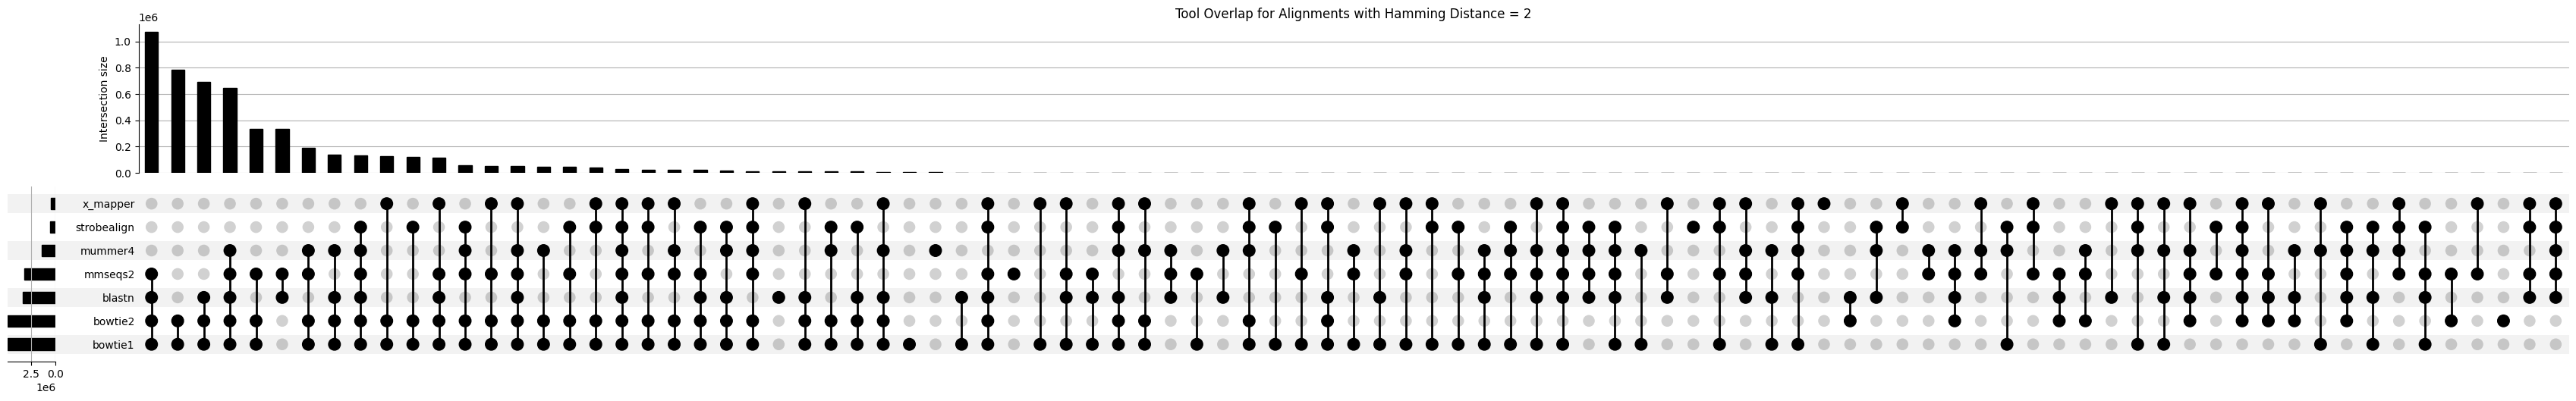

Generating upset plot for Hamming distance = 3
  Unique regions: 6,586,113, Tool combinations: 6,586,113


/tmp/ipykernel_1932608/3512946823.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

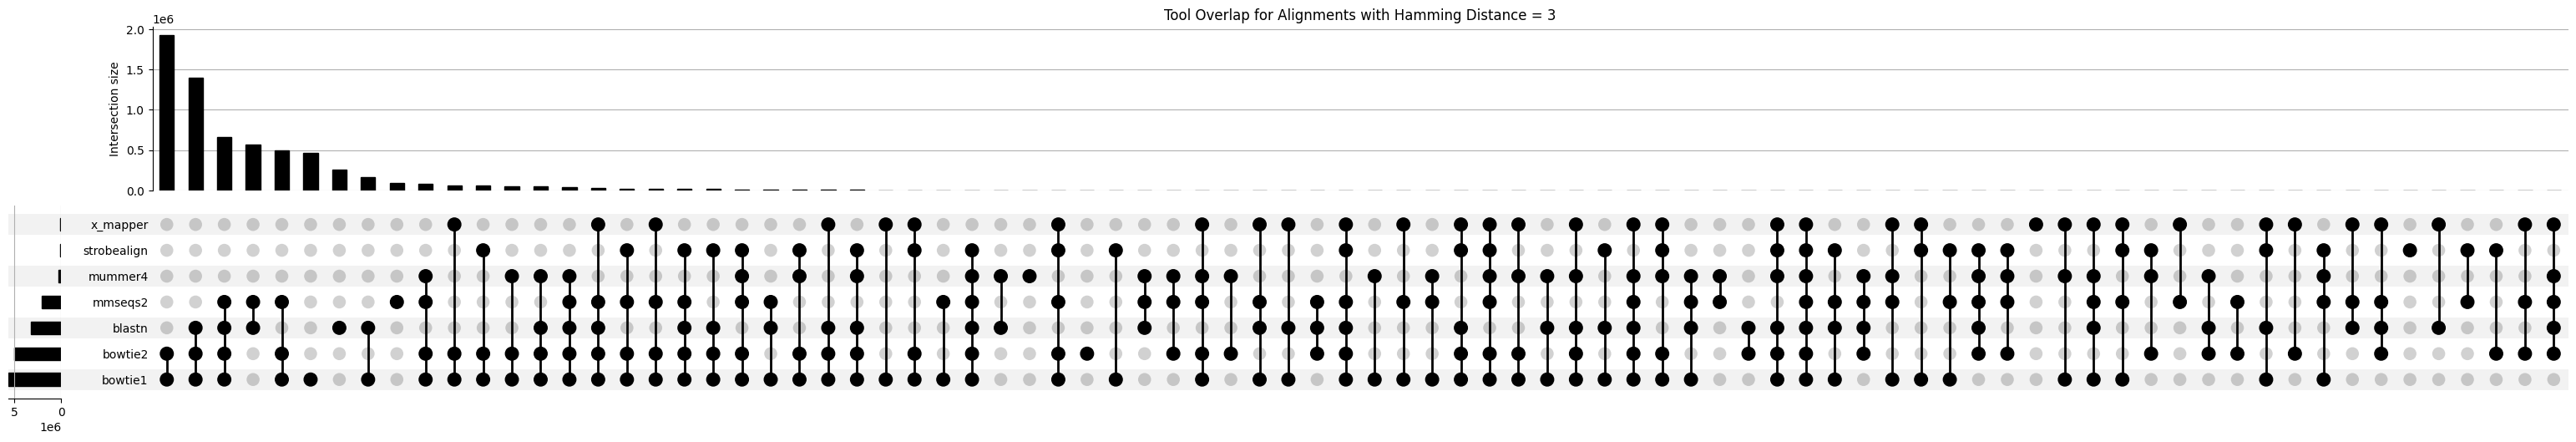

Upset plots saved to results/real_data/subsamples_analysis/plots_fraction_1


In [35]:
for hamming_dist in [0, 1, 2, 3]:
    print(f"Generating upset plot for Hamming distance = {hamming_dist}")
    
    tmp = results_hamming3.filter(pl.col('distance_hamming') == hamming_dist)
    
    # Group by region_idx to handle coordinate tolerance properly
    region_tools = tmp.select([
        'spacer_id', 'contig_id', 'region_idx', 'tool'
    ]).unique().group_by([
        'spacer_id', 'contig_id', 'region_idx'
    ]).agg([
        pl.col('tool').unique().sort().alias('tools')
    ])
    
    upset_data = up.from_memberships(region_tools['tools'])
    
    print(f"  Unique regions: {region_tools.height:,}, Tool combinations: {len(upset_data):,}")
    
    plt.figure(figsize=(12, 8))
    up.plot(upset_data, subset_size='count', sort_by='cardinality')
    plt.title(f'Tool Overlap for Alignments with Hamming Distance = {hamming_dist}')
    plt.tight_layout()
    plt.savefig(plot_dir / f'upset_hamming_{hamming_dist}.pdf')
    plt.savefig(plot_dir / f'upset_hamming_{hamming_dist}.png', dpi=150)
    plt.show()
    plt.close()

print(f"Upset plots saved to {plot_dir}")

### Tool Comparison Matrices

Create comparison matrices showing unique alignments in tool i but NOT in tool j. Uses region_idx to properly handle coordinate tolerance.

In [36]:
def create_tool_comparison_matrix(results_df, tools_list, hamming_dist):
    """Create matrix where cell(i,j) = alignments in tool i but NOT in tool j using region_idx."""
    tmp = results_df.filter(pl.col('distance_hamming') == hamming_dist)
    
    # Get unique regions for each tool using region_idx
    tool_alignments = {}
    for tool in tools_list:
        tool_alignments[tool] = tmp.filter(pl.col('tool') == tool).select([
            'spacer_id', 'contig_id', 'region_idx'
        ]).unique()
    
    # Create matrix
    matrix_data = np.zeros((len(tools_list), len(tools_list)), dtype=int)
    
    for i, tool_i in enumerate(tools_list):
        for j, tool_j in enumerate(tools_list):
            if tool_i == tool_j:
                continue
            
            unique_to_i = tool_alignments[tool_i].join(
                tool_alignments[tool_j],
                on=['spacer_id', 'contig_id', 'region_idx'],
                how='anti'
            )
            matrix_data[i, j] = unique_to_i.height
    
    matrix_df = pl.DataFrame(matrix_data, schema=tools_list)
    matrix_df = matrix_df.with_columns(
        pl.Series(name='tool', values=tools_list, dtype=pl.Utf8)
    ).select(['tool'] + tools_list)
    
    return matrix_df

# Generate matrices for each hamming distance
all_matrices = []

for hamming_dist in [0, 1, 2, 3]:
    print(f"Generating comparison matrix for Hamming = {hamming_dist}")
    
    matrix = create_tool_comparison_matrix(results_hamming3, tools_in_results, hamming_dist)
    
    matrix.write_csv(str(OUTPUT_DIR / f'matrix_hamming_{hamming_dist}_fraction_1.tsv'), separator='\t')
    
    all_matrices.append({'hamming_dist': hamming_dist, 'matrix': matrix})

print("Matrices saved")

Generating comparison matrix for Hamming = 0


Generating comparison matrix for Hamming = 1
Generating comparison matrix for Hamming = 2
Generating comparison matrix for Hamming = 3
Matrices saved


In [37]:
# Create heatmap visualizations for each matrix
charts = []

for item in all_matrices:
    hamming_dist = item['hamming_dist']
    matrix = item['matrix']
    
    # Melt matrix for altair
    matrix_long = matrix.unpivot(
        index='tool',
        on=[col for col in matrix.columns if col != 'tool'],
        variable_name='compared_to',
        value_name='count'
    )
    
    # Create heatmap
    chart = alt.Chart(matrix_long).mark_rect().encode(
        x=alt.X('tool:N', title='Tool', axis=alt.Axis(labelAngle=-45)),
        y=alt.Y('compared_to:N', title='Compared To'),
        color=alt.Color('count:Q', 
                       scale=alt.Scale(scheme='viridis'),
                       title='Unique to Tool'),
        tooltip=['tool:N', 'compared_to:N', 'count:Q']
    ).properties(
        width=400,
        height=400,
        title=f'Hamming Distance = {hamming_dist}'
    )
    
    charts.append(chart)

# Combine into grid
combined_chart = alt.hconcat(charts[0], charts[1]) & alt.hconcat(charts[2], charts[3])
combined_chart = combined_chart.resolve_scale(color='independent')

combined_chart.save(str(plot_dir / 'matrices_combined.html'))
combined_chart.save(str(plot_dir / 'matrices_combined.png'), scale_factor=2)

print("Combined matrix visualization saved")
combined_chart

Combined matrix visualization saved


alt.VConcatChart(...)

### Performance by Hamming Distance

Visualize how tool performance varies across different Hamming distance thresholds (0-3).

1. **Cumulative (≤)**: Shows recall for alignments with Hamming distance at or below each threshold
2. **Exact (==)**: Shows recall for alignments with exactly that Hamming distance

In [38]:
# Calculate tool performance by Hamming distance (cumulative and exact)

# CUMULATIVE (≤)
print("Calculating CUMULATIVE performance (≤ hamming distance)")

cumulative_performance = []

for threshold in [0, 1, 2, 3]:
    total_at_threshold = results_hamming3.filter(
        pl.col('distance_hamming') <= threshold
    ).select(['spacer_id', 'contig_id', 'region_idx']).unique()
    
    total_possible = total_at_threshold.height
    
    for tool in tools_in_results:
        tool_matches = results_hamming3.filter(
            (pl.col('distance_hamming') <= threshold) &
            (pl.col('tool') == tool)
        ).select(['spacer_id', 'contig_id', 'region_idx']).unique().height
        
        cumulative_performance.append({
            'distance_hamming': threshold,
            'tool': tool,
            'total_possible': total_possible,
            'tool_matches': tool_matches,
            'recall': tool_matches / total_possible if total_possible > 0 else 0
        })

hamming_performance_cumulative = pl.DataFrame(cumulative_performance)
hamming_performance_cumulative.write_csv(
    str(OUTPUT_DIR / 'tool_recall_by_hamming_distance_cumulative.tsv'),
    separator='\t'
)

# EXACT (==)
print("Calculating EXACT performance (== hamming distance)")

exact_performance = []

for distance in [0, 1, 2, 3]:
    total_at_distance = results_hamming3.filter(
        pl.col('distance_hamming') == distance
    ).select(['spacer_id', 'contig_id', 'region_idx']).unique()
    
    total_possible = total_at_distance.height
    
    for tool in tools_in_results:
        tool_matches = results_hamming3.filter(
            (pl.col('distance_hamming') == distance) &
            (pl.col('tool') == tool)
        ).select(['spacer_id', 'contig_id', 'region_idx']).unique().height
        
        exact_performance.append({
            'distance_hamming': distance,
            'tool': tool,
            'total_possible': total_possible,
            'tool_matches': tool_matches,
            'recall': tool_matches / total_possible if total_possible > 0 else 0
        })

hamming_performance_exact = pl.DataFrame(exact_performance)
hamming_performance_exact.write_csv(
    str(OUTPUT_DIR / 'tool_recall_by_hamming_distance_exact.tsv'),
    separator='\t'
)

# Visualize CUMULATIVE
plot_data_cumulative = hamming_performance_cumulative.select([
    'tool', 'distance_hamming', 'recall'
]).to_dict(as_series=False)

chart_cumulative = (
    ggplot(plot_data_cumulative, aes(x='distance_hamming', y='recall', color='tool', group='tool')) +
    geom_line(size=1.5) +
    geom_point(aes(shape='tool'), size=4) +
    scale_color_manual(values=tool_colors, name='Tool') +
    scale_shape_manual(values=tool_shapes, name='Tool') +
    scale_y_continuous(limits=[0, 1.05]) +
    scale_x_continuous(breaks=[0, 1, 2, 3]) +
    labs(
        x='Hamming Distance Threshold (≤)',
        y='Recall (fraction of alignments detected)',
        title='Tool Performance by Hamming Distance Threshold (Cumulative)'
    ) +
    ggsize(700, 450) +
    theme_minimal() +
    theme(plot_title=element_text(size=14, face='bold'), legend_position='right')
)

ggsave(chart_cumulative, str(plot_dir / 'tool_performance_by_hamming_distance_cumulative.html'))
ggsave(chart_cumulative, str(plot_dir / 'tool_performance_by_hamming_distance_cumulative.svg'))

# Visualize EXACT
plot_data_exact = hamming_performance_exact.select([
    'tool', 'distance_hamming', 'recall'
]).to_dict(as_series=False)

chart_exact = (
    ggplot(plot_data_exact, aes(x='distance_hamming', y='recall', color='tool', group='tool')) +
    geom_line(size=1.5) +
    geom_point(aes(shape='tool'), size=4) +
    scale_color_manual(values=tool_colors, name='Tool') +
    scale_shape_manual(values=tool_shapes, name='Tool') +
    scale_y_continuous(limits=[0, 1.05]) +
    scale_x_continuous(breaks=[0, 1, 2, 3]) +
    labs(
        x='Hamming Distance (exactly x)',
        y='Recall (fraction of alignments detected)',
        title='Tool Performance by Exact Hamming Distance'
    ) +
    ggsize(700, 450) +
    theme_minimal() +
    theme(plot_title=element_text(size=14, face='bold'), legend_position='right')
)

ggsave(chart_exact, str(plot_dir / 'tool_performance_by_hamming_distance_exact.html'))
ggsave(chart_exact, str(plot_dir / 'tool_performance_by_hamming_distance_exact.svg'))

chart_cumulative

Calculating CUMULATIVE performance (≤ hamming distance)
Calculating EXACT performance (== hamming distance)


In [40]:
chart_exact

## Step 5: Recall vs Number of Occurrences

Examine how tool recall varies with the number of times a spacer appears in the dataset. This reveals whether tools struggle with highly repetitive spacers.

In [41]:
def create_spacer_counts_with_tools(results_df, tools_list, hamming_distance=3, exact_or_max="exact"):
    """
    Create spacer occurrence counts with tool detection fractions.
    Uses region_idx to properly handle coordinate tolerance.
    """
    if exact_or_max == "max":
        spacer_counts = results_df.filter(pl.col('distance_hamming') <= hamming_distance)
    else:
        spacer_counts = results_df.filter(pl.col('distance_hamming') == hamming_distance)
    
    spacer_counts = spacer_counts.select(["spacer_id", "contig_id", "region_idx"])\
        .unique()\
        .group_by('spacer_id')\
        .agg(pl.count('region_idx').alias('n_occurrences'))

    # Calculate matches per tool and spacer using region_idx
    if exact_or_max == "max":
        tool_matches = results_df.filter(pl.col('distance_hamming') <= hamming_distance)
    else:
        tool_matches = results_df.filter(pl.col('distance_hamming') == hamming_distance)
    
    tool_matches = tool_matches.select(['spacer_id', 'tool', 'contig_id', 'region_idx'])\
        .unique()\
        .group_by(['spacer_id', 'tool'])\
        .agg(pl.count('region_idx').alias('tool_matches'))

    # Cross join and calculate fractions
    all_combinations = spacer_counts.select('spacer_id', 'n_occurrences')\
        .join(pl.DataFrame({'tool': tools_list}), how='cross')

    complete_fractions = all_combinations\
        .join(tool_matches, on=['spacer_id', 'tool'], how='left')\
        .with_columns([
            pl.col('tool_matches').fill_null(0),
            (pl.col('tool_matches') / pl.col('n_occurrences')).alias('fraction')
        ])

    # Pivot to tools as columns
    spacer_counts_with_tools = complete_fractions\
        .pivot(index=['spacer_id', 'n_occurrences'], on='tool', values='fraction')\
        .fill_null(0)
    
    return spacer_counts_with_tools

In [42]:
def plot_combined_recall_vs_occurrences(results_df, tools_list, n_high_occ_bins=3, 
                         output_prefix='results/real_data/subsamples_analysis/recall_vs_occurrences', 
                         max_bin=3, n_bins=150, color_dict=None, marker_dict=None, exact_or_max="exact",
                         plot_hamming_distances=[1,3]):
    """
    Plot recall vs number of occurrences for different Hamming distance thresholds.
    
    Args:
        results_df: DataFrame with validated alignments (long format)
        tools_list: List of tool names
        plot_hamming_distances: List of Hamming distances to plot
    """
    
    # Create color and marker dictionaries for consistent styling
    if color_dict is None:
        color_dict = tool_colors
    if marker_dict is None:
        markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', '+', 'x']
        marker_dict = {tool: markers[i % len(markers)] for i, tool in enumerate(tools_list)}

    # Create figure with subplots
    fig, axes = plt.subplots(len(plot_hamming_distances), 1, figsize=(15, 10 * len(plot_hamming_distances)))
    if len(plot_hamming_distances) == 1:
        axes = [axes]
    
    for i, hamming_dist in enumerate(plot_hamming_distances):
        # Create a new figure for the single plot
        fig_single, ax_single = plt.subplots(figsize=(15, 10))
        
        # Plot on both the combined and single figures
        plot_on_axis(axes[i], results_df, tools_list, n_high_occ_bins, n_bins, max_bin, 
                    hamming_distance=hamming_dist, exact_or_max=exact_or_max, color_dict=color_dict, 
                    marker_dict=marker_dict, output_prefix=output_prefix)
        plot_on_axis(ax_single, results_df, tools_list, n_high_occ_bins, n_bins, max_bin, 
                    hamming_distance=hamming_dist, exact_or_max=exact_or_max, color_dict=color_dict, 
                    marker_dict=marker_dict, output_prefix=output_prefix)
        
        # Set titles
        if exact_or_max == "exact":
            title = f'Recall vs number of occurrences (Hamming distance == {hamming_dist})'
        else:
            title = f'Recall vs number of occurrences (Hamming distance ≤ {hamming_dist})'
        axes[i].set_title(title)
        ax_single.set_title(title)
        
        # Save single plot
        plt.figure(fig_single.number)
        plt.tight_layout()
        fig_single.savefig(f'{output_prefix}_{exact_or_max}_hd_{hamming_dist}.pdf', bbox_inches='tight', format='pdf')
        fig_single.savefig(f'{output_prefix}_{exact_or_max}_hd_{hamming_dist}.png', bbox_inches='tight', format='png', dpi=150)
        plt.close(fig_single)
    
    # Save combined plot
    plt.figure(fig.number)
    plt.tight_layout()
    plot_distances_str = "_".join([str(d) for d in plot_hamming_distances])
    fig.savefig(f'{output_prefix}_{exact_or_max}_hd_{plot_distances_str}_combined.pdf', bbox_inches='tight')
    fig.savefig(f'{output_prefix}_{exact_or_max}_hd_{plot_distances_str}_combined.png', bbox_inches='tight', dpi=150)
    plt.show()

def plot_on_axis(ax: plt.Axes, results_df, tools_list, n_high_occ_bins, n_bins, max_bin, 
                 hamming_distance, exact_or_max, color_dict, marker_dict, output_prefix):
    """Helper function to plot on a given axis."""
    
    spacer_counts_with_tools = create_spacer_counts_with_tools(results_df, tools_list, 
                                                             hamming_distance=hamming_distance, 
                                                             exact_or_max=exact_or_max)

    # Create range bins for number of occurrences
    bins = np.logspace(np.log10(1), max_bin, n_bins)

    # Calculate mean fraction for each tool within each bin
    bin_stats = []
    for i in range(len(bins)-1):
        mask = (spacer_counts_with_tools['n_occurrences'] >= bins[i]) & \
               (spacer_counts_with_tools['n_occurrences'] < bins[i+1])
        bin_data = spacer_counts_with_tools.filter(mask)
        if bin_data.height > 0:
            stats = {
                'bin_start': bins[i],
                'bin_end': bins[i+1],
                'n_spacers': bin_data.height
            }
            for tool in tools_list:
                if tool in bin_data.columns:
                    stats[tool] = bin_data[tool].mean()
                else:
                    stats[tool] = 0.0
            bin_stats.append(stats)

    # Add points for high occurrences in multiple bins
    if n_high_occ_bins > 0:
        high_occ_edges = np.logspace(3, 4, n_high_occ_bins + 1)
        for i in range(n_high_occ_bins):
            bin_start = high_occ_edges[i]
            bin_end = high_occ_edges[i + 1]
            
            if i == n_high_occ_bins - 1:
                high_occ_mask = (spacer_counts_with_tools['n_occurrences'] >= bin_start)
            else:
                high_occ_mask = (spacer_counts_with_tools['n_occurrences'] >= bin_start) & \
                               (spacer_counts_with_tools['n_occurrences'] < bin_end)
            
            high_occ_data = spacer_counts_with_tools.filter(high_occ_mask)
            if high_occ_data.height > 0:
                high_occ_stats = {
                    'bin_start': bin_start,
                    'bin_end': bin_end,
                    'n_spacers': high_occ_data.height
                }
                for tool in tools_list:
                    if tool in high_occ_data.columns:
                        high_occ_stats[tool] = high_occ_data[tool].mean()
                    else:
                        high_occ_stats[tool] = 0.0
                bin_stats.append(high_occ_stats)

    # Plot on the provided axis
    for tool in tools_list:
        x = [(stat['bin_start'] + stat['bin_end'])/2 for stat in bin_stats]
        y = [stat[tool] for stat in bin_stats]
        ax.plot(x, y, label=tool, markersize=6, linewidth=2, 
                color=color_dict.get(tool, '#000000'), 
                markerfacecolor=color_dict.get(tool, '#000000'),
                marker=marker_dict.get(tool, 'o'))

    ax.set_xscale('log')
    ax.set_xlabel('Number of occurrences (log scale)', fontsize=12)
    ax.set_ylabel('Mean Detection Fraction', fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.grid(True, which="major", ls="-", alpha=0.5)
    ax.minorticks_on()
    ax.set_ylim(0, 1.05)
    ax.set_xlim(1, 10**4)

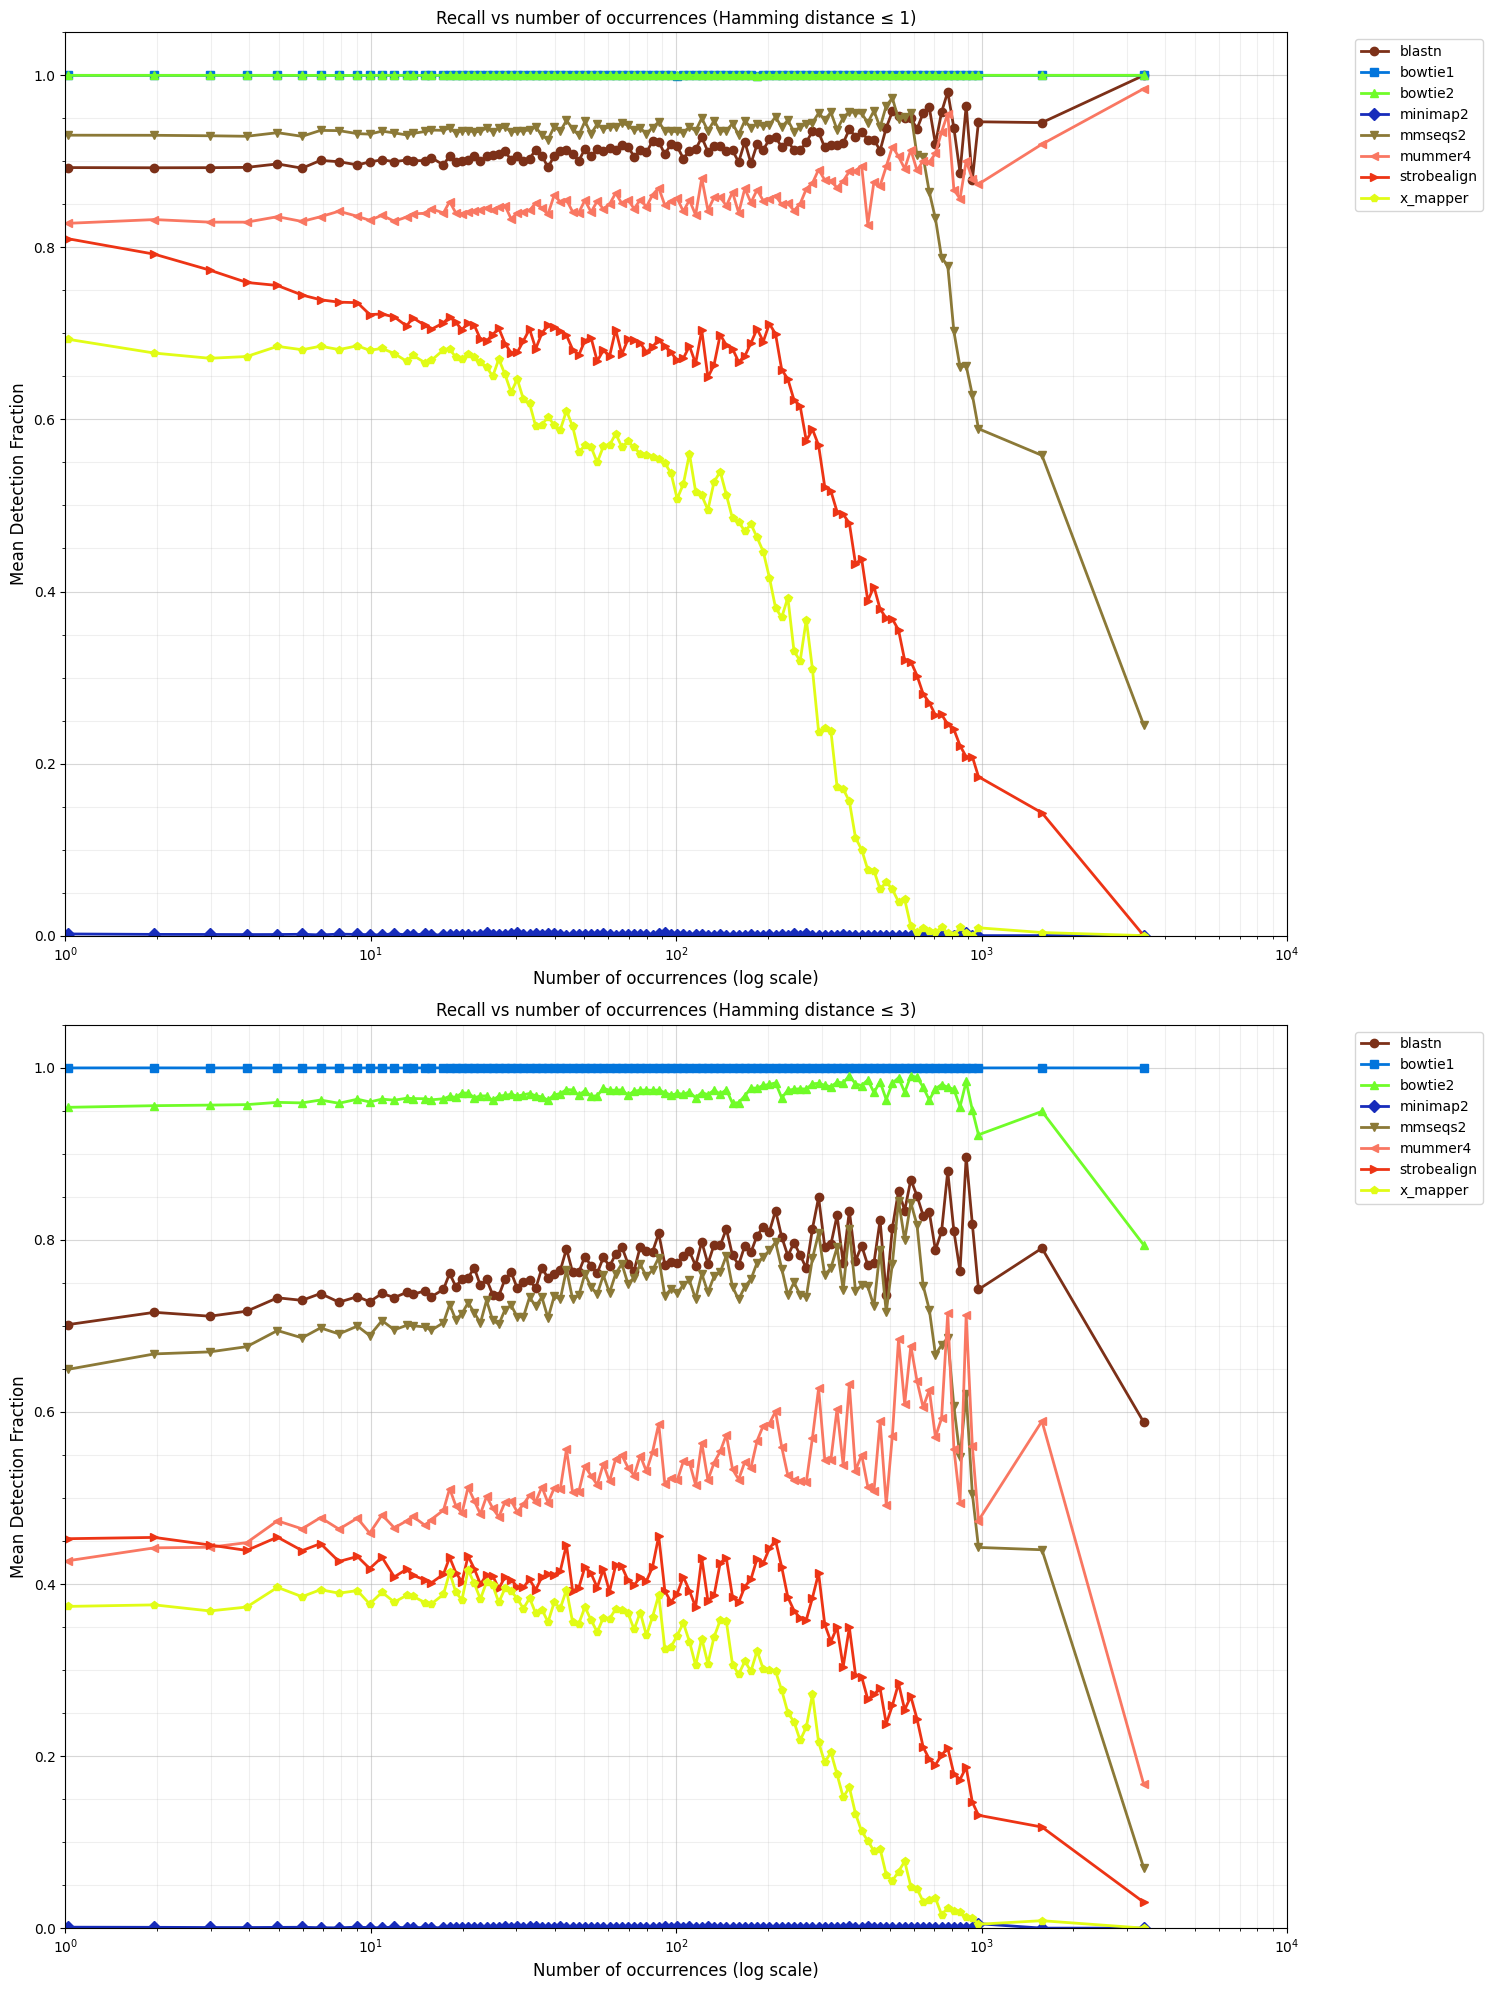

In [43]:
# Plot with Hamming distance ≤ 1 and ≤ 3 (cumulative)
plot_combined_recall_vs_occurrences(
    results_hamming3, 
    tools_in_results, 
    n_high_occ_bins=3, 
    output_prefix=str(plot_dir / 'recall_vs_occurrences'),
    exact_or_max="max",
    plot_hamming_distances=[1, 3]
)

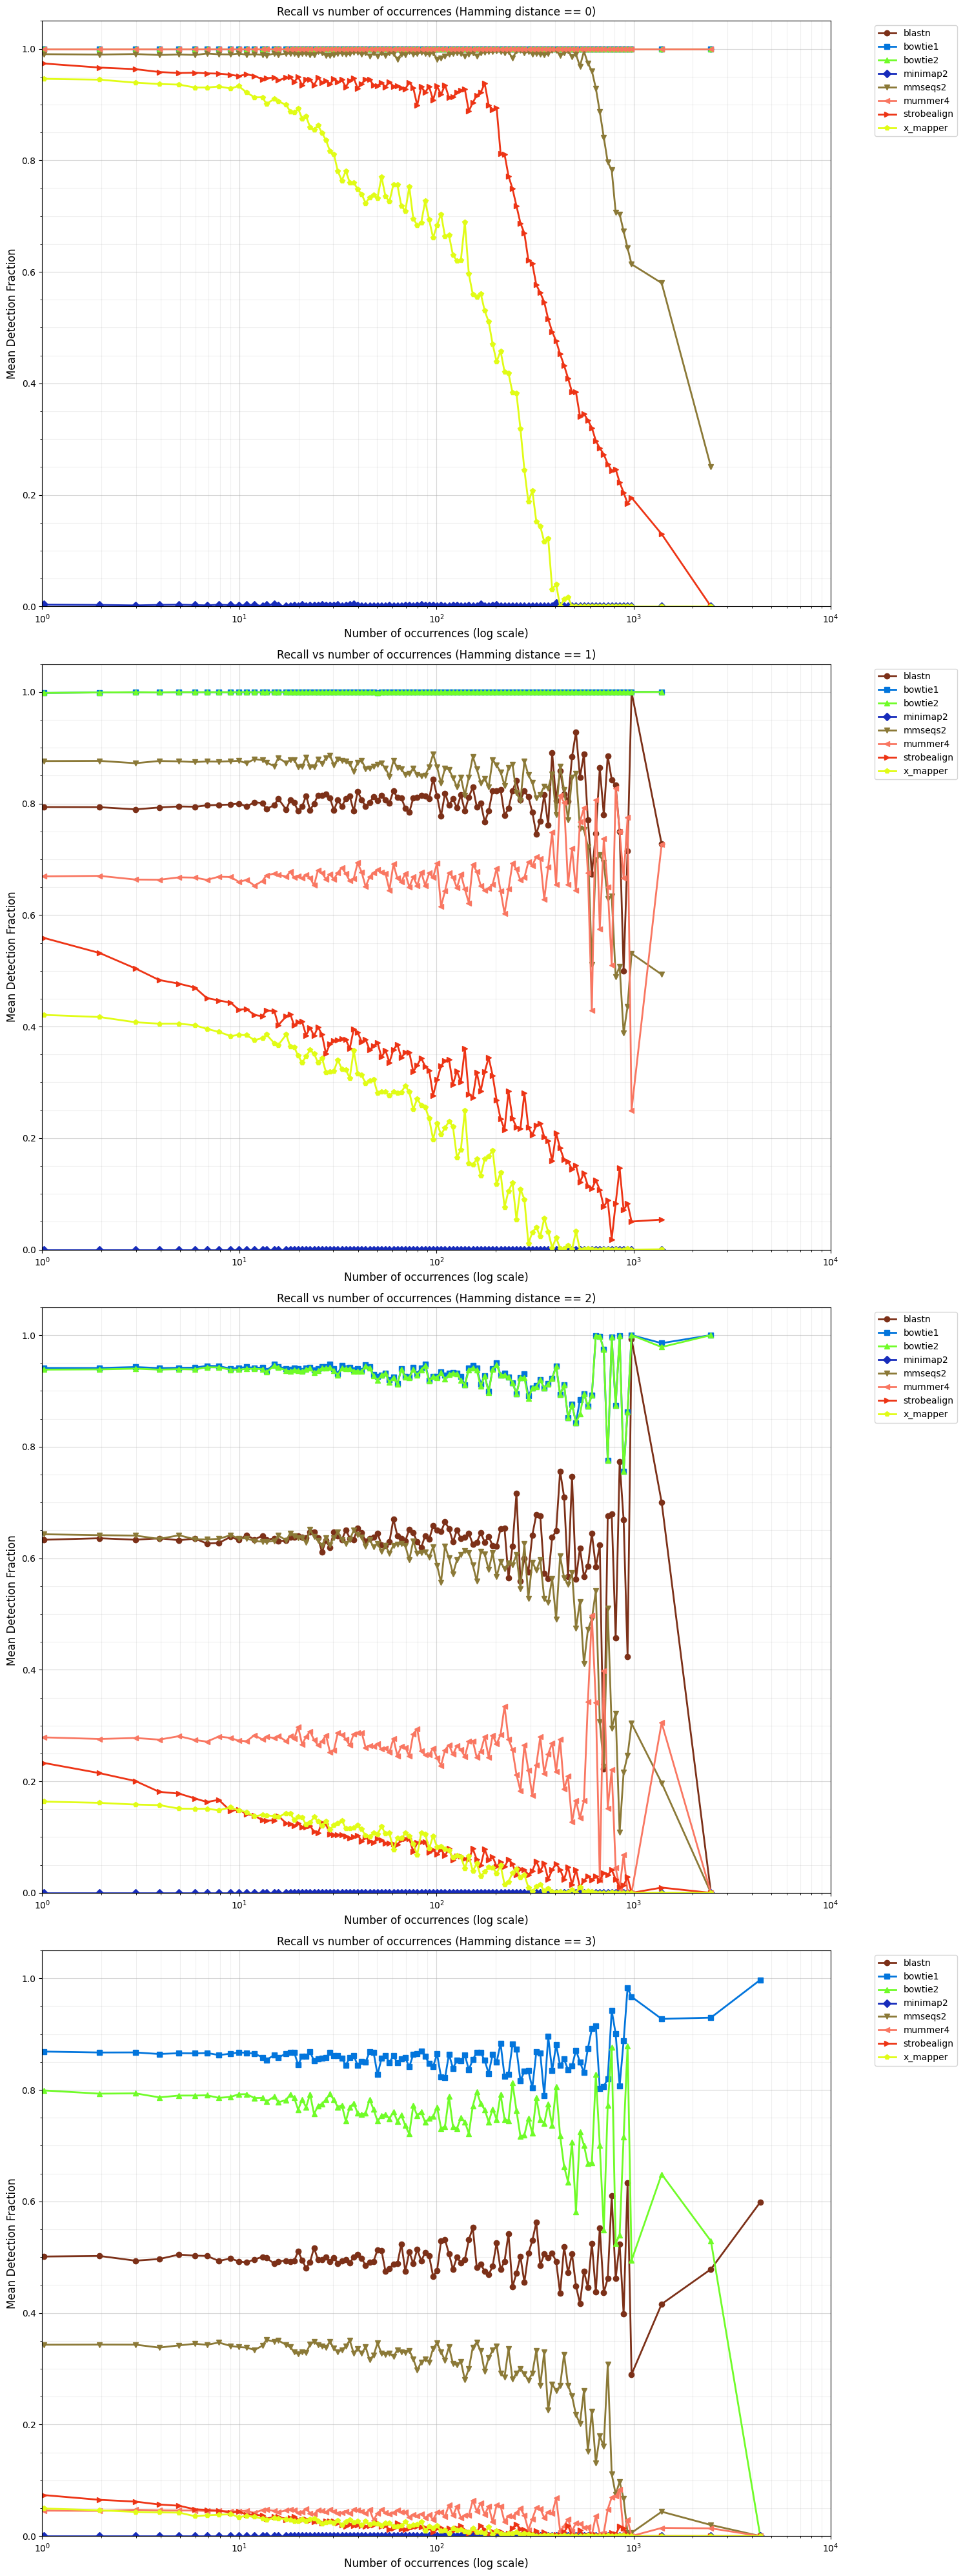

In [44]:
# Plot recall vs occurrences for different Hamming distances (exact values)
hamming_distances = [0, 1, 2, 3]
plot = plot_combined_recall_vs_occurrences(
    results_hamming3,
    tools_in_results,
    n_high_occ_bins=4,
    output_prefix=str(plot_dir / 'recall_vs_occurrences'),
    plot_hamming_distances=hamming_distances,
    exact_or_max="exact"
)

## Step 6: Distribution Analysis

Examine distributions of spacer lengths, Hamming distances, and occurrence counts.

In [45]:
# Prepare data for distribution analysis
spacer_counts_with_tools = create_spacer_counts_with_tools(
    results_hamming3, 
    tools_in_results, 
    hamming_distance=3,
    exact_or_max="max"
)

In [46]:
def plot_spacer_distributions(results_df, spacer_counts_with_tools, output_prefix='results/real_data/subsamples_analysis/plots_fraction_1'):
    """
    Create a three-panel figure showing spacer length, Hamming distance, and occurrence distributions.
    
    Args:
        results_df: DataFrame with validated alignments
        spacer_counts_with_tools: DataFrame with spacer occurrence counts
        output_prefix: Directory prefix for saving plots
    """
    # Get unique alignments for distribution analysis
    unique_alignments = results_df.select([
        'spacer_id', 'contig_id', 'start', 'end', 'strand', 'distance_hamming'
    ]).unique()
    
    # Calculate spacer lengths from alignment coordinates
    unique_alignments = unique_alignments.with_columns(
        (pl.col('end') - pl.col('start')).alias('spacer_length')
    )

    # Get distributions
    occurrence_df = spacer_counts_with_tools['n_occurrences'].value_counts()
    hamming_df = unique_alignments['distance_hamming'].value_counts()
    length_df = unique_alignments['spacer_length'].value_counts()

    # Chart 1: Spacer length distribution
    chart1 = alt.Chart(length_df).mark_bar().encode(
        x=alt.X('spacer_length:Q', 
                title='Spacer Length (bp)', 
                axis=alt.Axis(grid=True)),
        y=alt.Y("count:Q", 
                axis=alt.Axis(title="Number of Alignments", grid=True, gridDash=[2,2]))
    ).properties(
        title='A. Spacer Length Distribution',
        width=250,
        height=200
    )

    # Chart 2: Occurrence distribution (log scale)
    chart2 = alt.Chart(occurrence_df).mark_bar(opacity=0.7).encode(
        x=alt.X('n_occurrences:Q',
                scale=alt.Scale(type='log'),
                title='Number of Occurrences (log scale)'),
        y=alt.Y('count:Q', title='Number of Spacers')
    ).properties(
        title='B. Occurrence Distribution',
        width=250,
        height=200
    )

    # Chart 3: Hamming distance distribution
    chart3 = alt.Chart(hamming_df).mark_bar(width=40).encode(
        x=alt.X('distance_hamming:Q', 
                title='Hamming Distance', 
                axis=alt.Axis(grid=True)),
        y=alt.Y("count:Q", 
                axis=alt.Axis(title="Number of Alignments", grid=True, gridDash=[2,2]))
    ).properties(
        title='C. Hamming Distance Distribution',
        width=250,
        height=200
    )
    
    # Combine charts
    combined_chart = (chart1 | chart2 | chart3).configure_axis(
        labelFontSize=11,
        titleFontSize=12
    ).configure_title(
        anchor='start',
        fontSize=13
    )
    
    return combined_chart

In [22]:
# Create distribution plots
combined_chart = plot_spacer_distributions(
    results_df=results_hamming3,
    spacer_counts_with_tools=spacer_counts_with_tools
)
combined_chart

alt.HConcatChart(...)

In [49]:
# Save distribution plots
combined_chart.save(str(plot_dir / 'fraction_1_matched_spacers_distributions.html'))
combined_chart.save(str(plot_dir / 'fraction_1_matched_spacers_distributions.png'), scale_factor=2)

### Summary Statistics

In [50]:
# Summary statistics for fraction_1
unique_alignments = results_hamming3.select([
    'spacer_id', 'contig_id', 'start', 'end', 'distance_hamming'
]).unique()

unique_alignments = unique_alignments.with_columns(
    (pl.col('end') - pl.col('start')).alias('spacer_length')
)

print("Summary Statistics for Fraction_1 (Hamming ≤ 3):")
print(f"Spacer Lengths: mean={unique_alignments['spacer_length'].mean():.2f} bp, "
      f"median={unique_alignments['spacer_length'].median():.2f} bp, "
      f"std={unique_alignments['spacer_length'].std():.2f} bp")

print(f"Hamming Distances: mean={unique_alignments['distance_hamming'].mean():.2f}, "
      f"median={unique_alignments['distance_hamming'].median():.2f}, "
      f"std={unique_alignments['distance_hamming'].std():.2f}")

print(f"Occurrences per Spacer: mean={spacer_counts_with_tools['n_occurrences'].mean():.2f}, "
      f"median={spacer_counts_with_tools['n_occurrences'].median():.2f}, "
      f"std={spacer_counts_with_tools['n_occurrences'].std():.2f}")

print(f"\nDataset: {unique_alignments.height:,} unique alignments, "
      f"{unique_alignments['spacer_id'].n_unique():,} spacers, "
      f"{unique_alignments['contig_id'].n_unique():,} contigs, "
      f"{len(tools_in_results)} tools")

Summary Statistics for Fraction_1 (Hamming ≤ 3):
Spacer Lengths: mean=32.36 bp, median=33.00 bp, std=2.84 bp
Hamming Distances: mean=1.53, median=2.00, std=1.17
Occurrences per Spacer: mean=31.04, median=6.00, std=82.99

Dataset: 27,814,898 unique alignments, 750,245 spacers, 323,183 contigs, 8 tools


## Step 7: Smaller Subsample Analysis (fraction_0.01)

Analyze smaller fractions that include exhaustive tools (sassy, indelfree_bruteforce) which didn't complete on the full dataset. This allows comparison of all tools on a manageable dataset size.

In [51]:
# Load fraction_0.01 results
multi_metric_file_small = OUTPUT_DIR / 'multi_metric_fraction_0.01.parquet'

print("Loading fraction_0.01 results...")
results_small_df = pl.read_parquet(multi_metric_file_small)

results_small_hamming3 = results_small_df.filter(
    pl.col('distance_hamming') <= MAX_HAMMING_DISTANCE
).explode('tools').rename({'tools': 'tool'})

print(f"Total unique alignments: {results_small_df.height:,}")
print(f"Filtered to Hamming ≤ {MAX_HAMMING_DISTANCE}: {results_small_hamming3.height:,} alignments")
print(f"Unique regions (using region_idx): {results_small_hamming3.select('region_idx').n_unique():,}")

tools_in_small = results_small_hamming3.select('tool').unique().sort('tool')['tool'].to_list()
print(f"Tools: {tools_in_small}")

exhaustive_tools = set(tools_in_small) - set(tools_in_results)
print(f"Exhaustive tools (only in fraction_0.01): {sorted(exhaustive_tools)}")

Loading fraction_0.01 results...
Total unique alignments: 329,280
Filtered to Hamming ≤ 3: 1,796,580 alignments
Unique regions (using region_idx): 172,099
Tools: ['blastn', 'bowtie1', 'bowtie2', 'indelfree_bruteforce', 'indelfree_indexed', 'minimap2', 'mmseqs2', 'mummer4', 'sassy', 'strobealign', 'x_mapper']
Exhaustive tools (only in fraction_0.01): ['indelfree_bruteforce', 'indelfree_indexed', 'sassy']


Generating upset plot for fraction_0.01 (Hamming ≤ 3)
Unique regions: 172,099, Tool combinations: 172,099


/tmp/ipykernel_1932608/3287473428.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1400x1000 with 0 Axes>

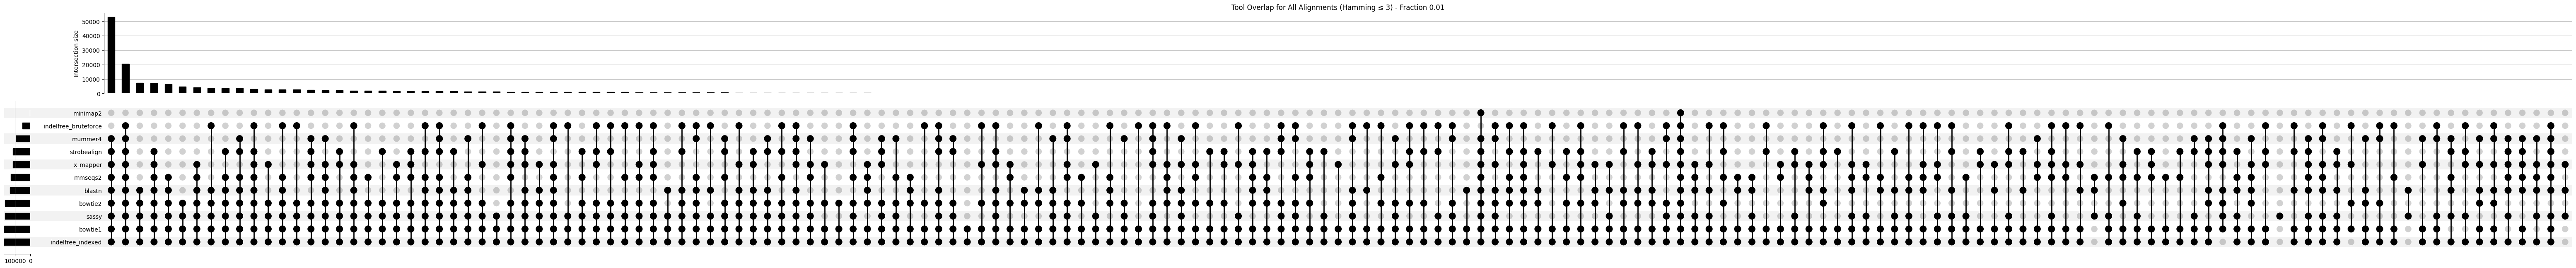

Upset plot saved to results/real_data/subsamples_analysis/plots_fraction_0.01


In [52]:
plot_dir_small = OUTPUT_DIR / 'plots_fraction_0.01'
plot_dir_small.mkdir(parents=True, exist_ok=True)

# Generate upset plot for all hamming distances combined
print("Generating upset plot for fraction_0.01 (Hamming ≤ 3)")

region_tools_small = results_small_hamming3.select([
    'spacer_id', 'contig_id', 'region_idx', 'tool'
]).unique().group_by([
    'spacer_id', 'contig_id', 'region_idx'
]).agg([
    pl.col('tool').unique().sort().alias('tools')
])

upset_data_small = up.from_memberships(region_tools_small['tools'])

print(f"Unique regions: {region_tools_small.height:,}, Tool combinations: {len(upset_data_small):,}")

plt.figure(figsize=(14, 10))
up.plot(upset_data_small, subset_size='count', sort_by='cardinality')
plt.title('Tool Overlap for All Alignments (Hamming ≤ 3) - Fraction 0.01')
plt.tight_layout()
plt.savefig(plot_dir_small / 'upset_all_tools_hamming_lte3.pdf')
plt.savefig(plot_dir_small / 'upset_all_tools_hamming_lte3.png', dpi=150)
plt.show()
plt.close()

print(f"Upset plot saved to {plot_dir_small}")

In [53]:
# Tool performance summary for fraction_0.01
summary_stats_small = results_small_hamming3.group_by('tool').agg([
    pl.len().alias('n_alignments'),
    pl.col('spacer_id').n_unique().alias('n_spacers'),
    pl.col('contig_id').n_unique().alias('n_contigs'),
    pl.col('distance_hamming').mean().alias('mean_hamming'),
    pl.col('distance_hamming').median().alias('median_hamming'),
    pl.col('distance_hamming').min().alias('min_hamming'),
    pl.col('distance_hamming').max().alias('max_hamming'),
]).sort('n_alignments', descending=True)

summary_stats_small.write_csv(str(OUTPUT_DIR / 'tool_summary_fraction_0.01.tsv'), separator='\t')

print("Tool Performance Summary for fraction_0.01 (Hamming ≤ 3):")
summary_stats_small

Tool Performance Summary for fraction_0.01 (Hamming ≤ 3):


tool,n_alignments,n_spacers,n_contigs,mean_hamming,median_hamming,min_hamming,max_hamming
str,u64,u64,u64,f64,f64,i64,i64
"""bowtie1""",235500,98915,2546,1.486412,1.0,0,3
"""indelfree_indexed""",235466,98917,2546,1.486389,1.0,0,3
"""bowtie2""",230164,96489,2243,1.45213,1.0,0,3
"""sassy""",225876,96850,2509,1.461665,1.0,0,3
"""x_mapper""",177486,73893,1811,1.196737,1.0,0,3
"""mmseqs2""",170448,78623,1799,1.147365,1.0,0,3
"""blastn""",169750,80180,2161,1.203293,1.0,0,3
"""strobealign""",156811,74243,1832,1.04383,1.0,0,3
"""mummer4""",122984,57502,1451,0.768002,1.0,0,3


### Cross-Dataset Comparison

Compare tool performance between fraction_1 and fraction_0.01.

In [55]:
# Compare across datasets
summary_stats_labeled = summary_stats.with_columns(pl.lit('fraction_1').alias('dataset'))
summary_stats_small_labeled = summary_stats_small.with_columns(pl.lit('fraction_0.01').alias('dataset'))

combined_summary = pl.concat([summary_stats_labeled, summary_stats_small_labeled])
combined_summary.write_csv(str(OUTPUT_DIR / 'tool_summary_combined.tsv'), separator='\t')

print("Combined Tool Performance Summary:")
print(combined_summary.sort(['tool', 'dataset']))

# Visualize comparison
chart = alt.Chart(combined_summary).mark_bar().encode(
    x=alt.X('tool:N', title='Tool', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('n_alignments:Q', title='Unique Alignments Detected'),
    color=alt.Color('dataset:N', title='Dataset'),
    column=alt.Column('dataset:N', title=None),
    tooltip=['tool:N', 'dataset:N', 'n_alignments:Q', 'n_spacers:Q', 'n_contigs:Q']
).properties(width=300, height=400, title='Tool Performance Comparison')

chart.save(str(OUTPUT_DIR / 'tool_comparison_across_datasets.html'))
print("Comparison chart saved")
chart

Combined Tool Performance Summary:
shape: (19, 9)
┌──────────────────────┬──────────────┬───────────┬───────────┬──────────────┬────────────────┬─────────────┬─────────────┬───────────────┐
│ tool                 ┆ n_alignments ┆ n_spacers ┆ n_contigs ┆ mean_hamming ┆ median_hamming ┆ min_hamming ┆ max_hamming ┆ dataset       │
│ ---                  ┆ ---          ┆ ---       ┆ ---       ┆ ---          ┆ ---            ┆ ---         ┆ ---         ┆ ---           │
│ str                  ┆ u64          ┆ u64       ┆ u64       ┆ f64          ┆ f64            ┆ i64         ┆ i64         ┆ str           │
╞══════════════════════╪══════════════╪═══════════╪═══════════╪══════════════╪════════════════╪═════════════╪═════════════╪═══════════════╡
│ blastn               ┆ 169750       ┆ 80180     ┆ 2161      ┆ 1.203293     ┆ 1.0            ┆ 0           ┆ 3           ┆ fraction_0.01 │
│ blastn               ┆ 20142598     ┆ 649595    ┆ 273656    ┆ 1.144347     ┆ 1.0            ┆ 0           ┆ 

alt.Chart(...)

In [56]:
# Analyze exhaustive tools if present
if len(exhaustive_tools) > 0:
    print(f"Analyzing exhaustive tools: {sorted(exhaustive_tools)}")
    
    exhaustive_summary = summary_stats_small.filter(pl.col('tool').is_in(list(exhaustive_tools)))
    non_exhaustive_summary = summary_stats_small.filter(~pl.col('tool').is_in(list(exhaustive_tools)))
    
    print("\nExhaustive tools performance:")
    print(exhaustive_summary)
    
    print("\nTop non-exhaustive tools:")
    print(non_exhaustive_summary.sort('n_alignments', descending=True).head(3))
    
    # Check regions ONLY found by exhaustive tools using region_idx
    exhaustive_only_regions = results_small_hamming3.filter(
        pl.col('tool').is_in(list(exhaustive_tools))
    ).select(['spacer_id', 'contig_id', 'region_idx']).unique()
    
    non_exhaustive_regions = results_small_hamming3.filter(
        ~pl.col('tool').is_in(list(exhaustive_tools))
    ).select(['spacer_id', 'contig_id', 'region_idx']).unique()
    
    only_by_exhaustive = exhaustive_only_regions.join(
        non_exhaustive_regions,
        on=['spacer_id', 'contig_id', 'region_idx'],
        how='anti'
    )
    
    print(f"\nUnique regions ONLY found by exhaustive tools: {only_by_exhaustive.height:,}")
    print(f"Total unique regions: {region_tools_small.height:,}")
    print(f"Percentage unique to exhaustive: {only_by_exhaustive.height / region_tools_small.height * 100:.2f}%")
else:
    print("No exhaustive tools found in fraction_0.01")

Analyzing exhaustive tools: ['indelfree_bruteforce', 'indelfree_indexed', 'sassy']

Exhaustive tools performance:
shape: (3, 8)
┌──────────────────────┬──────────────┬───────────┬───────────┬──────────────┬────────────────┬─────────────┬─────────────┐
│ tool                 ┆ n_alignments ┆ n_spacers ┆ n_contigs ┆ mean_hamming ┆ median_hamming ┆ min_hamming ┆ max_hamming │
│ ---                  ┆ ---          ┆ ---       ┆ ---       ┆ ---          ┆ ---            ┆ ---         ┆ ---         │
│ str                  ┆ u64          ┆ u64       ┆ u64       ┆ f64          ┆ f64            ┆ i64         ┆ i64         │
╞══════════════════════╪══════════════╪═══════════╪═══════════╪══════════════╪════════════════╪═════════════╪═════════════╡
│ indelfree_indexed    ┆ 235466       ┆ 98917     ┆ 2546      ┆ 1.486389     ┆ 1.0            ┆ 0           ┆ 3           │
│ sassy                ┆ 225876       ┆ 96850     ┆ 2509      ┆ 1.461665     ┆ 1.0            ┆ 0           ┆ 3           │
│ in

## Summary

### Analysis Complete

All results saved to `results/real_data/subsamples_analysis/`:

**Key outputs for paper:**
- `summary_table_for_paper.tsv` - Dataset characteristics, tool completion status, and alignment counts
- `tool_recall_stats_across_fractions.tsv` - Tool performance consistency metrics
- `recall_error_bars_by_tool.(html|svg)` - Main figure showing tool reliability across dataset sizes
- Multi-metric validated parquets for all fractions
- Tool performance summaries, comparison matrices, and upset plots
- Recall vs occurrence analyses and distribution plots

**Analysis highlights:**
- Tracks all fractions automatically with metadata (size, tools completed, timeouts)
- Uses `region_idx` consistently to avoid double-counting alignments with slight boundary shifts
- Multi-fraction analysis demonstrates tool performance consistency, justifying extrapolation

In [ ]:
%%bash
# Archive analysis results
tar -czf results/real_data/subsamples_analysis.tar.gz results/real_data/subsamples_analysis/
realpath results/real_data/subsamples_analysis.tar.gz
# # echo "Archive created: results/real_data/subsamples_analysis.tar.gz"

In [ ]:
%%bash
du -sh results/real_data/subsamples_analysis.tar.gz